## Dog vs Cat Classification using Convolution Neural Networks
---
The data used in this exercise are very close to the real world images which are of different sizes and are colored.

GNU Wget is a computer program that retrieves content from web servers.

Zipfile library allowing you to unzip the data. We refer to the filepath of zipfile and extract it to /tmp folder. The folder has train and validation subfolders which will help us to label the images automatically using ImageGenerator.

In [1]:
import zipfile
local_zip = 'cats_and_dogs_filtered.zip'

zip_ref = zipfile.ZipFile(local_zip,'r')
zip_ref.extractall('/tmp')
zip_ref.close()


FileNotFoundError: ignored

The following python code will use the OS library to use Operating System libraries, giving you access to the file system

In [0]:
import os

base_dir = '/tmp/cats_and_dogs_filtered/'
train_dir = os.path.join(base_dir,'train')
validation_dir = os.path.join(base_dir,'validation')

#Directory with Cats and Dog image for training

train_cats_dir = os.path.join(train_dir,'cats')
train_dogs_dir = os.path.join(train_dir,'dogs')

#Directory with Cats and Dog image for validation

validation_cats_dir = os.path.join(validation_dir,'cats')
validation_dogs_dir = os.path.join(validation_dir,'dogs')


Now lets see the filenames in each directory

In [3]:
train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

print(train_cat_fnames[:10])
print(train_dog_fnames[:10])

['cat.774.jpg', 'cat.419.jpg', 'cat.160.jpg', 'cat.622.jpg', 'cat.977.jpg', 'cat.955.jpg', 'cat.30.jpg', 'cat.482.jpg', 'cat.211.jpg', 'cat.689.jpg']
['dog.17.jpg', 'dog.937.jpg', 'dog.634.jpg', 'dog.471.jpg', 'dog.315.jpg', 'dog.802.jpg', 'dog.292.jpg', 'dog.499.jpg', 'dog.297.jpg', 'dog.550.jpg']


Find out number of cat and dog images in each set

In [4]:
print('Total Cat images in Train :', len(os.listdir(train_cats_dir)))
print('Total Dog images in Train :', len(os.listdir(train_dogs_dir)))

print('Total Cat images in Validation :', len(os.listdir(validation_cats_dir)))
print('Total Dog images in Validation :', len(os.listdir(validation_dogs_dir)))

Total Cat images in Train : 1000
Total Dog images in Train : 1000
Total Cat images in Validation : 500
Total Dog images in Validation : 500


Lets look at few pictures

In [0]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

#Define Image Size to plot
nrows=4
ncols=4

pic_index=8 #No of images to display


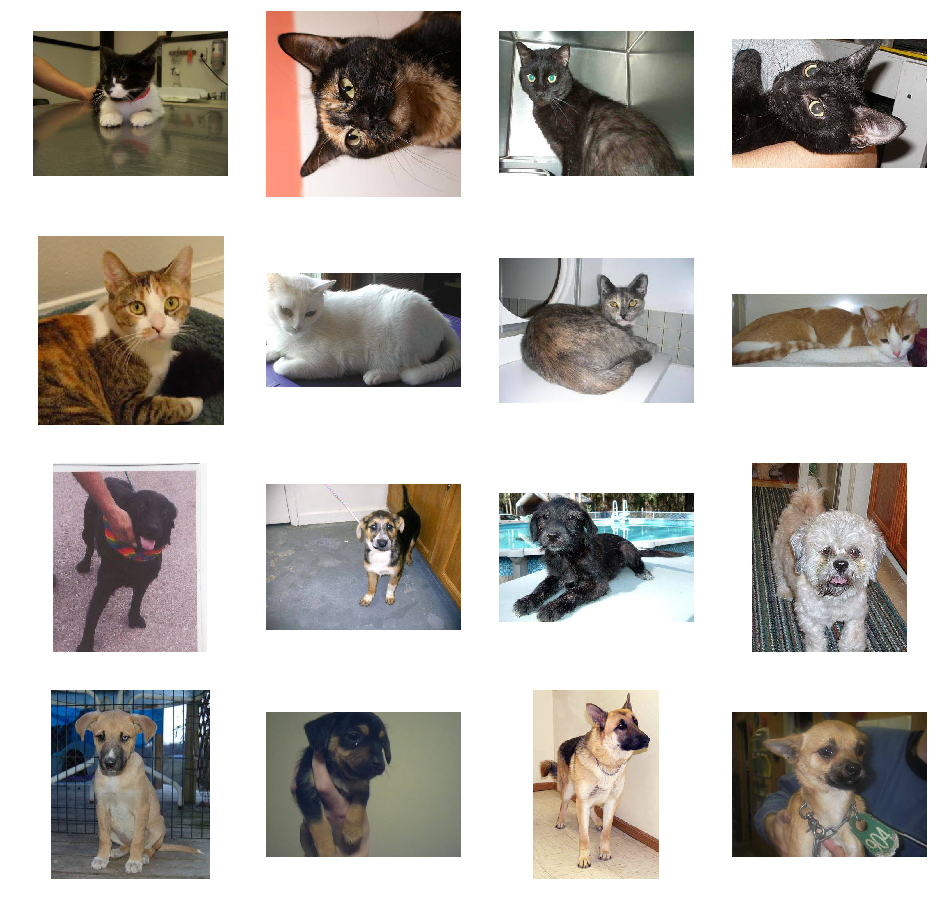

In [6]:
fig = plt.gcf()
fig.set_size_inches(ncols*4,nrows*4)


cats_pic = [os.path.join(train_cats_dir,fname) for fname in train_cat_fnames[pic_index-8:pic_index]]
dogs_pic = [os.path.join(train_dogs_dir,fname) for fname in train_dog_fnames[pic_index-8:pic_index]]

pic_name = cats_pic+dogs_pic

for i,img_path in enumerate(pic_name):
  #Setup Subplots
  sp = plt.subplot(nrows,ncols,i+1)
  sp.axis('Off')
  img = mpimg.imread(img_path)
  plt.imshow(img)
 
plt.show()
  

## **Building a basic model to classify**

1. Import TensorFlow

In [0]:
import tensorflow as tf

Each image is of different size. We will be preprocessing it to be 150 x 150 x 3 where 3 is for the color depth. 

Processed image will be fed into Convolution Neural Networks(CNN) whose output will be flattened and fed as an input to Deep Neural Networks(DNN)
This is a Binary Classification problem which will use Sigmoid function at the output instead of softmax function.

In [8]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16,(3,3),activation = 'relu', input_shape=(150,150,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32,(3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    #Flatten the result
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512,activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

W0808 19:39:01.632558 140122798761856 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 18496)             0

We will train our model with the **binary_crossentropy loss,** because it's a binary classification problem and our final activation is a sigmoid. We will use the **rmsprop optimizer** with a learning rate of 0.00.RMSprop automates learning-rate tuning for us. (Other optimizers, such as Adam and Adagrad, also automatically adapt the learning rate during training, and would work equally well here.)

In [10]:
from tensorflow.keras.optimizers import RMSprop

model.compile(optimizer=RMSprop(lr=0.001),
             loss='binary_crossentropy',
             metrics=['acc'])

W0808 19:39:05.273612 140122798761856 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## Data Preprocessing

### Data Preprocessing

Let's set up data generators that will read pictures in our source folders, convert them to `float32` tensors, and feed them (with their labels) to our network. We'll have one generator for the training images and one for the validation images. Our generators will yield batches of 20 images of size 150x150 and their labels (binary).

As you may already know, data that goes into neural networks should usually be normalized in some way to make it more amenable to processing by the network. (It is uncommon to feed raw pixels into a convnet.) In our case, we will preprocess our images by normalizing the pixel values to be in the `[0, 1]` range (originally all values are in the `[0, 255]` range).

In Keras this can be done via the `keras.preprocessing.image.ImageDataGenerator` class using the `rescale` parameter. This `ImageDataGenerator` class allows you to instantiate generators of augmented image batches (and their labels) via `.flow(data, labels)` or `.flow_from_directory(directory)`. These generators can then be used with the Keras model methods that accept data generators as inputs: `fit_generator`, `evaluate_generator`, and `predict_generator`.

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255.
train_datagen = ImageDataGenerator( rescale = 1.0/255. )
test_datagen  = ImageDataGenerator( rescale = 1.0/255. )

# --------------------
# Flow training images in batches of 20 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(150, 150))     
# --------------------
# Flow validation images in batches of 20 using test_datagen generator
# --------------------
validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                         batch_size=20,
                                                         class_mode  = 'binary',
                                                         target_size = (150, 150))



Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


### Training
Let's train on all 2,000 images available, for 15 epochs, and validate on all 1,000 test images. (This may take a few minutes to run.)

Do note the values per epoch.

You'll see 4 values per epoch -- Loss, Accuracy, Validation Loss and Validation Accuracy. 

The Loss and Accuracy are a great indication of progress of training. It's making a guess as to the classification of the training data, and then measuring it against the known label, calculating the result. Accuracy is the portion of correct guesses. The Validation accuracy is the measurement with the data that has not been used in training. As expected this would be a bit lower.



In [12]:
history = model.fit_generator(train_generator,
                              validation_data=validation_generator,
                              steps_per_epoch=100,
                              epochs=15,
                              validation_steps=50,
                              verbose=2)

Epoch 1/15
100/100 - 12s - loss: 0.8012 - acc: 0.5510 - val_loss: 0.6770 - val_acc: 0.5700
Epoch 2/15
100/100 - 7s - loss: 0.6644 - acc: 0.6195 - val_loss: 0.6480 - val_acc: 0.5960
Epoch 3/15
100/100 - 7s - loss: 0.5892 - acc: 0.7065 - val_loss: 0.6089 - val_acc: 0.6630
Epoch 4/15
100/100 - 7s - loss: 0.4775 - acc: 0.7680 - val_loss: 0.5994 - val_acc: 0.7020
Epoch 5/15
100/100 - 7s - loss: 0.4049 - acc: 0.8080 - val_loss: 0.6192 - val_acc: 0.7280
Epoch 6/15
100/100 - 7s - loss: 0.3100 - acc: 0.8650 - val_loss: 0.6377 - val_acc: 0.7350
Epoch 7/15
100/100 - 7s - loss: 0.2328 - acc: 0.9025 - val_loss: 0.7301 - val_acc: 0.7250
Epoch 8/15
100/100 - 7s - loss: 0.1553 - acc: 0.9350 - val_loss: 0.8892 - val_acc: 0.7190
Epoch 9/15
100/100 - 7s - loss: 0.1004 - acc: 0.9645 - val_loss: 1.1874 - val_acc: 0.7170
Epoch 10/15
100/100 - 7s - loss: 0.0827 - acc: 0.9750 - val_loss: 1.3044 - val_acc: 0.7360
Epoch 11/15
100/100 - 8s - loss: 0.0660 - acc: 0.9770 - val_loss: 1.2331 - val_acc: 0.6980
Epoch 1

## Running the Model
Let's now take a look at actually running a prediction using the model.

In [14]:
import numpy as np

from google.colab import files
from keras.preprocessing import image

uploaded=files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path='/content/' + fn
  img=image.load_img(path, target_size=(150, 150))
  
  x=image.img_to_array(img)
  x=np.expand_dims(x, axis=0)
  images = np.vstack([x])
  
  classes = model.predict(images, batch_size=10)
  
  print(classes[0])
  
  if classes[0]>0:
    print(fn + " is a dog")
    
  else:
    print(fn + " is a cat")

Saving image copy.png to image copy.png
[0.]
image copy.png is a cat


### Visualizing Intermediate Representations

To get a feel for what kind of features our convnet has learned, one fun thing to do is to visualize how an input gets transformed as it goes through the convnet.

Let's pick a random cat or dog image from the training set, and then generate a figure where each row is the output of a layer, and each image in the row is a specific filter in that output feature map. Rerun this cell to generate intermediate representations for a variety of training images.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in true_divide


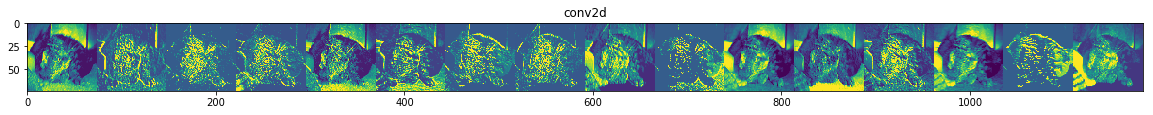

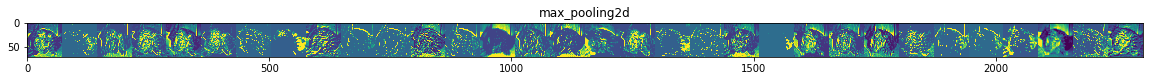

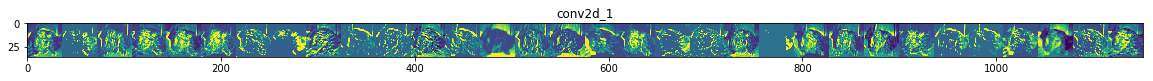

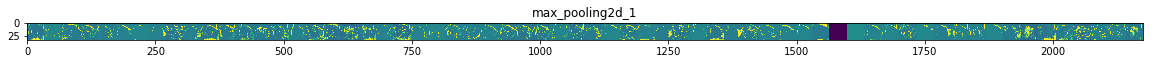

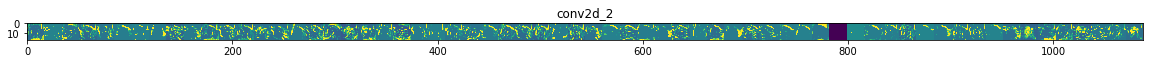

In [15]:
import numpy as np
import random
from   tensorflow.keras.preprocessing.image import img_to_array, load_img

# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers

successive_outputs = [layer.output for layer in model.layers[1:]]

#visualization_model = Model(img_input, successive_outputs)

visualization_model = tf.keras.models.Model(inputs = model.input,outputs=successive_outputs)

#Take a random cat or dog image and process it to feed to the network

cat_img_files = [os.path.join(train_cats_dir,f) for f in train_cat_fnames]
dog_img_files = [os.path.join(train_dogs_dir,f) for f in train_dog_fnames]

img_path = random.choice(cat_img_files + dog_img_files)
img = load_img(img_path, target_size=(150,150))

x = img_to_array(img)  # Numpy array with shape (150,150,3)
x = x.reshape((1,) + x.shape) # Numpy array with shape (1,150,150,3)

#Rescale 
x /= 255.0

#Lets pass the image through our network.

successive_feature_maps = visualization_model.predict(x)

#Get layer names
layer_names = [layer.name for layer in model.layers]

#Display our representations

for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  
  if len(feature_map.shape)==4:
    #conv2d_3 (1, 74, 74, 16) shape = 4, size = 74, feature = 16
    #dense_2 (1, 1) shape = 2
    n_features = feature_map.shape[-1]
    size = feature_map.shape[1]

    #Create image tiles
    display_grid = np.zeros((size,size*n_features))
    
    #-------------------------------------------------
    # Postprocess the feature to be visually palatable
    #-------------------------------------------------
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      display_grid[:, i * size : (i + 1) * size] = x # Tile each filter into a horizontal grid

    #-----------------
    # Display the grid
    #-----------------

    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' ) 

## Evaluating Accuracy and Loss for the Model
Let's plot the training/validation accuracy and loss as collected during training:

Text(0.5, 1.0, 'Training and validation loss')

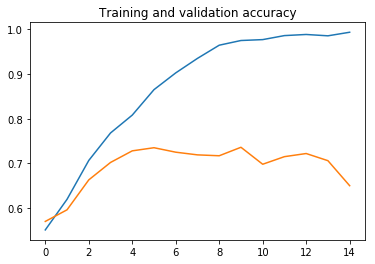

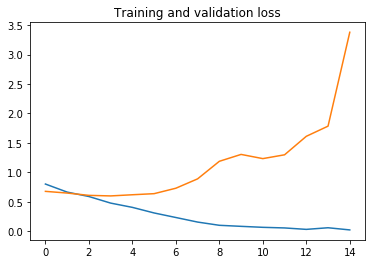

In [16]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history.history[     'acc' ]
val_acc  = history.history[ 'val_acc' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  ( epochs,     acc )
plt.plot  ( epochs, val_acc )
plt.title ('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs,     loss )
plt.plot  ( epochs, val_loss )
plt.title ('Training and validation loss'   )

As you can see, we are **overfitting** like it's getting out of fashion. Our training accuracy (in blue) gets close to 100% (!) while our validation accuracy (in green) stalls as 70%. Our validation loss reaches its minimum after only five epochs.

We can add **Augmentation** to the same Convolutional Neural Network to see how it gives us better training data that overfits less! Now take a look at the ImageGenerator. There are properties on it that you can use to augment the image. 

```
# Updated to do image augmentation
train_datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
```
These are just a few of the options available (for more, see the Keras documentation. Let's quickly go over what we just wrote:

* rotation_range is a value in degrees (0–180), a range within which to randomly rotate pictures.
* width_shift and height_shift are ranges (as a fraction of total width or height) within which to randomly translate pictures vertically or horizontally.
* shear_range is for randomly applying shearing transformations.
* zoom_range is for randomly zooming inside pictures.
* horizontal_flip is for randomly flipping half of the images horizontally. This is relevant when there are no assumptions of horizontal assymmetry (e.g. real-world pictures).
* fill_mode is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.



In [17]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,  # 2000 images = batch_size * steps
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50,  # 1000 images = batch_size * steps
      verbose=2)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/100
100/100 - 16s - loss: 0.7848 - acc: 0.6365 - val_loss: 0.5577 - val_acc: 0.7270
Epoch 2/100
100/100 - 15s - loss: 0.6313 - acc: 0.6530 - val_loss: 0.5332 - val_acc: 0.7360
Epoch 3/100
100/100 - 15s - loss: 0.6126 - acc: 0.6755 - val_loss: 0.5500 - val_acc: 0.7160
Epoch 4/100
100/100 - 15s - loss: 0.6016 - acc: 0.6950 - val_loss: 0.5390 - val_acc: 0.7320
Epoch 5/100
100/100 - 15s - loss: 0.6057 - acc: 0.6790 - val_loss: 0.5298 - val_acc: 0.7430
Epoch 6/100
100/100 - 15s - loss: 0.5778 - acc: 0.7050 - val_loss: 0.5103 - val_acc: 0.7500
Epoch 7/100
100/100 - 15s - loss: 0.5800 - acc: 0.7035 - val_loss: 0.5259 - val_acc: 0.7430
Epoch 8/100
100/100 - 14s - loss: 0.5717 - acc: 0.7155 - val_loss: 0.5084 - val_acc: 0.7460
Epoch 9/100
100/100 - 14s - loss: 0.5822 - acc: 0.6950 - val_loss: 0.5932 - val_acc: 0.7160
Epoch 10/100
100/100 - 14s - loss: 0.5688 - acc: 0.7225 - val_loss: 0.5215 - val_acc: 0.

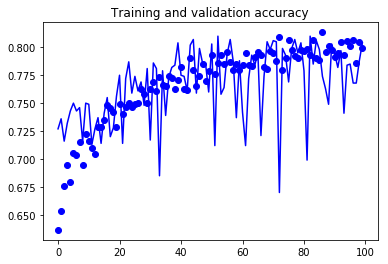

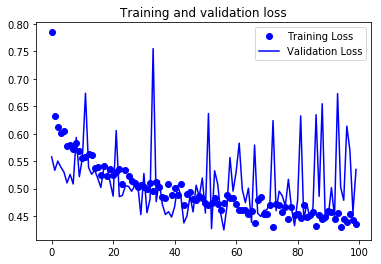

In [18]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()